Data sourced from [moneypuck.com](https://moneypuck.com/data.htm)

# Packages

In [249]:
import glob
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Read Data

In [250]:
df: pl.DataFrame = pl.concat(
    [pl.read_csv(csv_file) for csv_file in glob.glob("./Data/*.csv")],
    how="vertical"
)

df.sample(n=5, seed=20)

playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,unblocked_shot_attempts,xRebounds,rebounds,xFreeze,freeze,xOnGoal,ongoal,xPlayStopped,playStopped,xPlayContinuedInZone,playContinuedInZone,xPlayContinuedOutsideZone,playContinuedOutsideZone,flurryAdjustedxGoals,lowDangerShots,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties
i64,i64,str,str,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
8480373,2020,"""Josef Korenar""","""S.J""","""G""","""all""",10,29510.0,21.33,26.0,476.0,18.21,16.0,58.91,73.0,255.31,258.0,7.46,6.0,142.81,101.0,103.8,131.0,20.61,271.0,66.0,16.0,7.71,8.16,5.45,10.0,9.0,7.0,123.0,0.0,0.0
8467913,2009,"""Alex Auld""","""NYR""","""G""","""other""",24,2764.0,3.71,4.0,66.0,2.4,2.0,7.91,8.0,37.82,36.0,1.02,1.0,20.16,17.0,16.6,18.0,3.52,40.0,8.0,4.0,1.4,0.94,1.37,1.0,2.0,1.0,14.0,0.0,0.0
8481668,2024,"""Arturs Silovs""","""VAN""","""G""","""4on5""",10,2713.0,3.94,4.0,63.0,2.67,3.0,6.35,5.0,30.32,30.0,0.23,0.0,19.0,15.0,9.98,16.0,3.87,31.0,7.0,5.0,1.02,0.79,2.13,0.0,1.0,3.0,20.0,0.0,0.0
8475660,2019,"""Cam Talbot""","""CGY""","""G""","""other""",26,1792.0,2.24,3.0,47.0,1.82,1.0,5.32,7.0,27.11,32.0,0.6,0.0,17.03,17.0,10.8,11.0,2.17,33.0,3.0,3.0,1.07,0.33,0.85,2.0,0.0,1.0,8.0,0.0,0.0
8471239,2014,"""Cory Schneider""","""N.J""","""G""","""all""",69,235436.0,166.23,148.0,3436.0,128.56,111.0,433.73,487.0,1914.2,1982.0,51.2,51.0,1055.58,787.0,788.75,1038.0,160.49,1978.0,516.0,140.0,56.67,62.75,46.8,48.0,57.0,43.0,802.0,0.0,0.0


# Feature Selection

- I could explore feature selection models.
- For now I've chosen features I think are important based off my own knowledge of the NHL and hockey.

In [251]:
# include aggregate stats of all situations (5on5, 5on4, 4on5, etc.)
df = df.filter(pl.col('situation') == 'all')

# # i could potentially explore feature selection models
df = df.select([
    "season",              # the year of the season played
    "name",                # the goalie's name
    "games_played",        # total number of games played for a season
    "xGoals",              # total number of goals expected to be allowed
    "goals",               # total number of goals actually allowed
    "xRebounds",           # total number of rebounds expected to allow
    "rebounds",            # total number of rebounds given from shots on goal
    "ongoal",              # total number of shots on goal faced
    "lowDangerxGoals",     # goals expected to allow from low danger shots
    "mediumDangerxGoals",  # goals expected to allow from medium danger shots
    "highDangerxGoals",    # goals expected to allow from high danger shots
    "lowDangerGoals",      # goals actually allowed from low danger shots
    "mediumDangerGoals",   # goals actually allowed from medium danger shots
    "highDangerGoals"      # goals actually allowed from high danger shots
])

df.sample(n=5, seed=20)

season,name,games_played,xGoals,goals,xRebounds,rebounds,ongoal,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals
i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2020,"""Sergei Bobrovsky""",31,79.88,88.0,60.09,85.0,933.0,25.58,28.56,25.73,25.0,33.0,30.0
2009,"""Steve Mason""",57,127.82,163.0,104.78,88.0,1614.0,46.36,42.75,38.7,59.0,59.0,45.0
2024,"""Connor Hellebuyck""",60,155.87,120.0,119.89,195.0,1576.0,51.63,51.25,52.99,50.0,33.0,37.0
2019,"""Elvis Merzlikins""",32,68.84,71.0,58.71,57.0,919.0,29.16,25.36,14.33,32.0,27.0,12.0
2014,"""Cory Schneider""",69,166.23,148.0,128.56,111.0,1982.0,56.67,62.75,46.8,48.0,57.0,43.0


In [252]:
df.describe()

statistic,season,name,games_played,xGoals,goals,xRebounds,rebounds,ongoal,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1598.0,"""1598""",1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2016.295369,null,27.143304,68.6452,68.976846,52.602522,58.82791,765.296621,23.096902,24.473191,21.074975,23.997497,24.660826,20.318523
"""std""",4.894797,null,20.523826,54.021054,52.297402,41.420043,48.698128,604.477073,18.16468,19.10398,17.369629,18.498625,18.88664,16.596219
"""min""",2008.0,"""Aaron Dell""",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",2012.0,null,7.0,17.51,20.0,13.04,14.0,191.0,5.75,6.36,5.1,7.0,7.0,5.0
"""50%""",2016.0,null,25.0,59.4,62.0,46.35,50.0,669.0,20.52,21.83,17.85,22.0,22.0,17.0
"""75%""",2021.0,null,43.0,108.82,110.0,83.48,92.0,1207.0,36.45,39.3,33.84,38.0,39.0,33.0
"""max""",2024.0,"""Zane McIntyre""",77.0,217.67,209.0,168.82,222.0,2375.0,75.81,83.57,78.93,76.0,91.0,75.0


# Feature Engineering

In [253]:
# creating a goals against average feature
df = df.with_columns(
    goals_against_avg=pl.col("goals") / pl.col("games_played")
)

# +/- goals allowed vs expected
df = df.with_columns(
    goals_vs_expected=pl.col("goals") - pl.col("xGoals")
)

# +/- rebounds alloed vs expected
df = df.with_columns(
    rebounds_vs_expected=pl.col("rebounds") - pl.col("xRebounds")
)

# save percentage for the season
df = df.with_columns(
    save_percentage=1 - (pl.col("goals") / pl.col("ongoal"))
)

In [254]:
# creating the target variable (is the vezina winner)
df = df.with_columns(
    is_vezina=0
)

vezina_map = {
    2008: "Tim Thomas",
    2009: "Ryan Miller",
    2010: "Tim Thomas",
    2011: "Henrik Lundqvist",
    2012: "Sergei Bobrovsky",
    2013: "Tuukka Rask",
    2014: "Carey Price",
    2015: "Braden Holtby",
    2016: "Sergei Bobrovsky",
    2017: "Pekka Rinne",
    2018: "Andrei Vasilevskiy",
    2019: "Connor Hellebuyck",
    2020: "Marc-Andre Fleury",
    2021: "Igor Shesterkin",
    2022: "Linus Ullmark",
    2023: "Connor Hellebuyck",
}

for season, player in vezina_map.items():
    df = df.with_columns(
        pl.when((pl.col("season") == season) & (pl.col("name") == player))
        .then(1)
        .otherwise(pl.col("is_vezina"))
        .alias("is_vezina")
    )

df.filter(pl.col("is_vezina") == 1)

season,name,games_played,xGoals,goals,xRebounds,rebounds,ongoal,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,goals_against_avg,goals_vs_expected,rebounds_vs_expected,save_percentage,is_vezina
i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
2012,"""Sergei Bobrovsky""",38,80.86,74.0,71.39,74.0,1084.0,30.8,30.66,19.39,26.0,29.0,19.0,1.947368,-6.86,2.61,0.931734,1
2013,"""Tuukka Rask""",58,125.08,115.0,105.34,96.0,1641.0,47.09,46.17,31.82,46.0,29.0,40.0,1.982759,-10.08,-9.34,0.929921,1
2011,"""Henrik Lundqvist""",62,148.83,123.0,118.77,109.0,1753.0,54.33,52.12,42.38,51.0,36.0,36.0,1.983871,-25.83,-9.77,0.929835,1
2010,"""Tim Thomas""",57,151.56,112.0,116.95,105.0,1811.0,52.53,56.15,42.87,33.0,41.0,38.0,1.964912,-39.56,-11.95,0.938156,1
2014,"""Carey Price""",66,163.16,130.0,133.31,133.0,1953.0,57.84,59.11,46.21,44.0,41.0,45.0,1.969697,-33.16,-0.31,0.933436,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2009,"""Ryan Miller""",69,179.38,150.0,139.69,118.0,2098.0,67.3,70.4,41.69,59.0,51.0,40.0,2.173913,-29.38,-21.69,0.928503,1
2008,"""Tim Thomas""",53,137.13,112.0,104.48,103.0,1664.0,47.01,47.37,42.75,33.0,45.0,34.0,2.113208,-25.13,-1.48,0.932692,1
2020,"""Marc-Andre Fleury""",36,88.92,71.0,68.06,96.0,989.0,29.09,30.91,28.92,20.0,30.0,21.0,1.972222,-17.92,27.94,0.92821,1


In [255]:
df.sample(n=5, seed=20)

season,name,games_played,xGoals,goals,xRebounds,rebounds,ongoal,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,goals_against_avg,goals_vs_expected,rebounds_vs_expected,save_percentage,is_vezina
i64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
2020,"""Sergei Bobrovsky""",31,79.88,88.0,60.09,85.0,933.0,25.58,28.56,25.73,25.0,33.0,30.0,2.83871,8.12,24.91,0.905681,0
2009,"""Steve Mason""",57,127.82,163.0,104.78,88.0,1614.0,46.36,42.75,38.7,59.0,59.0,45.0,2.859649,35.18,-16.78,0.899009,0
2024,"""Connor Hellebuyck""",60,155.87,120.0,119.89,195.0,1576.0,51.63,51.25,52.99,50.0,33.0,37.0,2.0,-35.87,75.11,0.923858,0
2019,"""Elvis Merzlikins""",32,68.84,71.0,58.71,57.0,919.0,29.16,25.36,14.33,32.0,27.0,12.0,2.21875,2.16,-1.71,0.922742,0
2014,"""Cory Schneider""",69,166.23,148.0,128.56,111.0,1982.0,56.67,62.75,46.8,48.0,57.0,43.0,2.144928,-18.23,-17.56,0.925328,0


# Data Visualization

In [256]:
vezina_df: pl.DataFrame = df.filter(
    pl.col("is_vezina") == 1
)

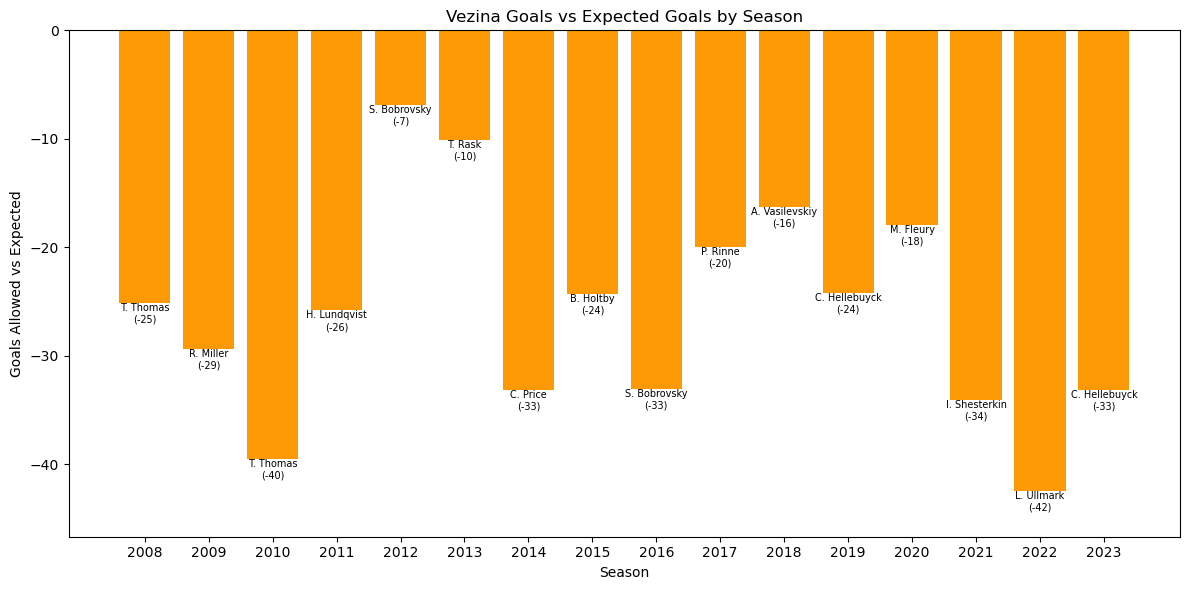

In [257]:
plt.figure(figsize=(12, 6))

bars = plt.bar(
    vezina_df["season"].to_list(),
    vezina_df["goals_vs_expected"].to_list(),
    color="#fc9905"
)
plt.title("Vezina Goals vs Expected Goals by Season")
plt.xlabel("Season")
plt.ylabel("Goals Allowed vs Expected")
plt.xticks(vezina_df["season"].to_list())

for idx, season in enumerate(vezina_df["season"].to_list()):
    gve: float = vezina_df.filter(pl.col("season") == season)["goals_vs_expected"].to_list()[0]
    name: str = vezina_df.filter(pl.col("season") == season)["name"].to_list()[0]
    plt.text(
        season, gve,
        f"{name.split()[0][0]}. {name.split()[-1]}\n({gve:.0f})",
        fontsize=7, ha="center", va="top"
    )

plt.margins(y=0.1)
plt.tight_layout()
plt.show()

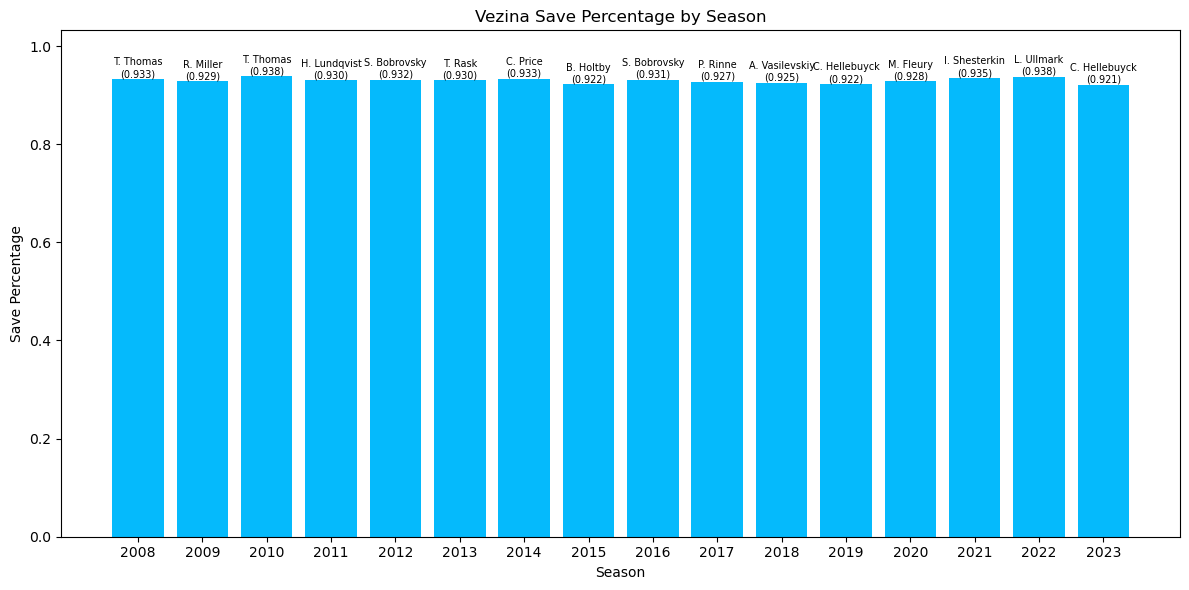

In [258]:
plt.figure(figsize=(12, 6))

bars = plt.bar(
    vezina_df["season"].to_list(), 
    vezina_df["save_percentage"].to_list(),
    color="#05bafc"
)
plt.title("Vezina Save Percentage by Season")
plt.xlabel("Season")
plt.ylabel("Save Percentage")
plt.xticks(vezina_df["season"].to_list())

for idx, season in enumerate(vezina_df["season"].to_list()):
    svpt: float = vezina_df.filter(pl.col("season") == season)["save_percentage"].to_list()[0]
    name: str = vezina_df.filter(pl.col("season") == season)["name"].to_list()[0]
    plt.text(
        season, svpt, 
        f"{name.split()[0][0]}. {name.split()[-1]}\n({svpt:.3f})", 
        fontsize=7, ha="center", va="bottom"
    )

plt.margins(y=0.1)
plt.tight_layout()
plt.show()

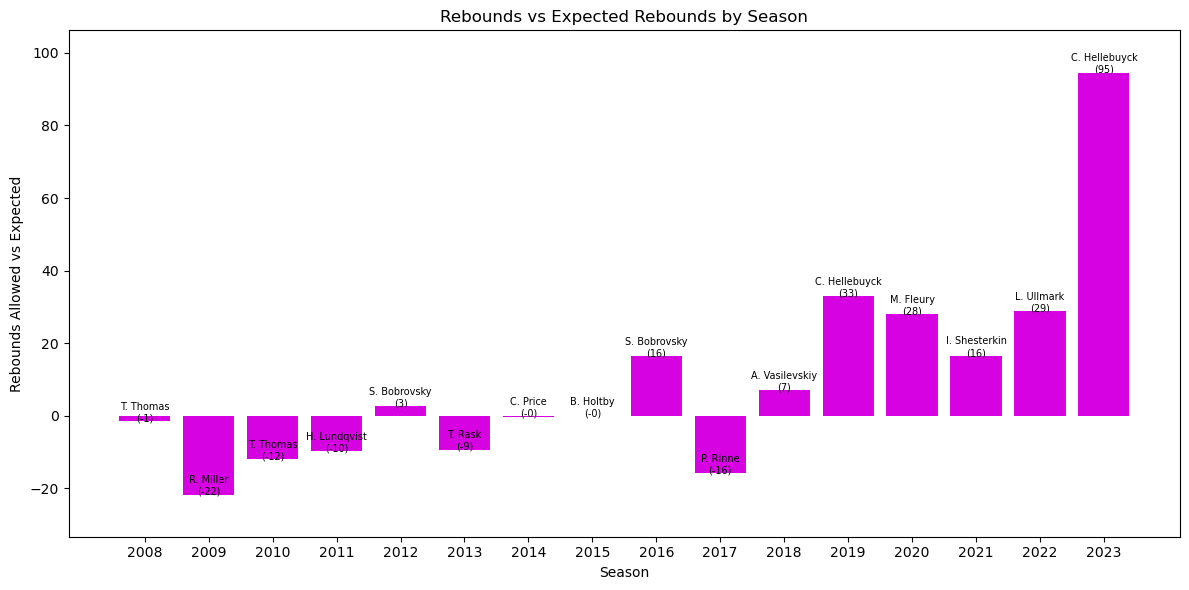

In [259]:
plt.figure(figsize=(12, 6))

bars = plt.bar(
    vezina_df["season"].to_list(),
    vezina_df["rebounds_vs_expected"].to_list(),
    color="#d702e2"
)
plt.title("Rebounds vs Expected Rebounds by Season")
plt.xlabel("Season")
plt.ylabel("Rebounds Allowed vs Expected")
plt.xticks(vezina_df["season"].to_list())

for idx, season in enumerate(vezina_df["season"].to_list()):
    gve: float = vezina_df.filter(pl.col("season") == season)["rebounds_vs_expected"].to_list()[0]
    name: str = vezina_df.filter(pl.col("season") == season)["name"].to_list()[0]
    plt.text(
        season, gve,
        f"{name.split()[0][0]}. {name.split()[-1]}\n({gve:.0f})",
        fontsize=7, ha="center"
    )

plt.margins(y=0.1)
plt.tight_layout()
plt.show()

# Feature Cleaning & Scaling

In [260]:
df.describe()

statistic,season,name,games_played,xGoals,goals,xRebounds,rebounds,ongoal,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,goals_against_avg,goals_vs_expected,rebounds_vs_expected,save_percentage,is_vezina
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1598.0,"""1598""",1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2016.295369,null,27.143304,68.6452,68.976846,52.602522,58.82791,765.296621,23.096902,24.473191,21.074975,23.997497,24.660826,20.318523,2.544406,0.331646,6.225388,NaN,0.010013
"""std""",4.894797,null,20.523826,54.021054,52.297402,41.420043,48.698128,604.477073,18.16468,19.10398,17.369629,18.498625,18.88664,16.596219,0.760657,9.662835,16.222885,NaN,0.099592
"""min""",2008.0,"""Aaron Dell""",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-46.67,-40.65,0.5,0.0
"""25%""",2012.0,null,7.0,17.51,20.0,13.04,14.0,191.0,5.75,6.36,5.1,7.0,7.0,5.0,2.235294,-3.5,-1.85,0.893805,0.0
"""50%""",2016.0,null,25.0,59.4,62.0,46.35,50.0,669.0,20.52,21.83,17.85,22.0,22.0,17.0,2.535714,0.92,1.77,0.90806,0.0
"""75%""",2021.0,null,43.0,108.82,110.0,83.48,92.0,1207.0,36.45,39.3,33.84,38.0,39.0,33.0,2.875,5.37,10.56,0.917788,0.0
"""max""",2024.0,"""Zane McIntyre""",77.0,217.67,209.0,168.82,222.0,2375.0,75.81,83.57,78.93,76.0,91.0,75.0,7.0,40.89,94.57,1.0,1.0


In [261]:
def min_max_scaler(df: pl.DataFrame, column: str) -> pl.DataFrame:
    min: float = df[column].min()
    max: float = df[column].max()

    df = df.with_columns(
        ((pl.col(column) - min) / (max - min)).alias(column)
    )

    return df


cols_not_scaling: list[str] = ["season", "name", "save_percentage", "is_vezina"]

for column in df.columns:
    if column not in cols_not_scaling:
        df = min_max_scaler(df, column)

In [262]:
df.describe()

statistic,season,name,games_played,xGoals,goals,xRebounds,rebounds,ongoal,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,goals_against_avg,goals_vs_expected,rebounds_vs_expected,save_percentage,is_vezina
str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1598.0,"""1598""",1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0,1598.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2016.295369,null,0.343991,0.315364,0.330033,0.311589,0.264991,0.32223,0.304668,0.292847,0.267008,0.315757,0.270998,0.270914,0.363487,0.536794,0.34666,NaN,0.010013
"""std""",4.894797,null,0.27005,0.248179,0.250227,0.24535,0.219361,0.254517,0.239608,0.228599,0.220064,0.243403,0.207545,0.221283,0.108665,0.110357,0.119974,NaN,0.099592
"""min""",2008.0,"""Aaron Dell""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
"""25%""",2012.0,null,0.078947,0.080443,0.095694,0.077242,0.063063,0.080421,0.075848,0.076104,0.064614,0.092105,0.076923,0.066667,0.319328,0.493033,0.28694,0.893805,0.0
"""50%""",2016.0,null,0.315789,0.27289,0.296651,0.274553,0.225225,0.281684,0.270677,0.261218,0.22615,0.289474,0.241758,0.226667,0.362245,0.543513,0.313711,0.90806,0.0
"""75%""",2021.0,null,0.552632,0.499931,0.526316,0.494491,0.414414,0.508211,0.480807,0.470264,0.428734,0.5,0.428571,0.44,0.410714,0.594335,0.378716,0.917788,0.0
"""max""",2024.0,"""Zane McIntyre""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Modeling

In [263]:
# splitting up training and testing data
# based on the season selected
# all data from before the selected season will be used to train
dont_train_cols: list[str] = [
    "name", "season", "is_vezina", "xGoals", "xRebounds",
    "lowDangerxGoals", "mediumDangerxGoals", "highDangerxGoals"
]

season: int = 2023

train_df: pl.DataFrame = df.filter(pl.col("season") < season).clone()
test_df: pl.DataFrame = df.filter(pl.col("season") == season).clone()

X_train: pl.DataFrame = train_df.drop(dont_train_cols)
y_train: pl.Series = train_df["is_vezina"]

X_test: pl.DataFrame = test_df.drop(dont_train_cols)
y_test: pl.Series = test_df["is_vezina"]

In [264]:
# impute for nulls
# i have found no nulls anywhere, so not sure where there are any

imputer = SimpleImputer(strategy="mean")

X_train = imputer.fit_transform(X_train)
X_test = imputer.fit_transform(X_test)

In [265]:
# set up and train the linear regression model
linear_regression_ml: LinearRegression = LinearRegression()
linear_regression_ml.fit(X_train, y_train)

LinearRegression()

In [266]:
y_pred: np.ndarray = linear_regression_ml.predict(X_test)

test_df = test_df.with_columns(
    pl.Series("vezina_proba", y_pred)
)

# Results

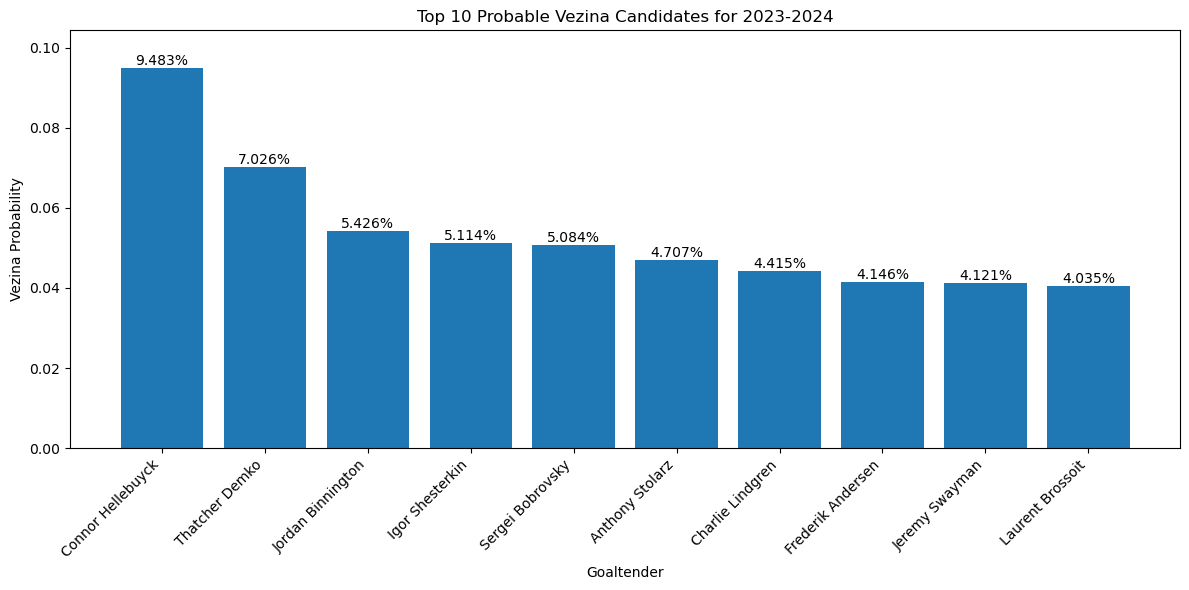

In [267]:
results_df = (
    test_df
    .select(["name", "vezina_proba"])
    .sort("vezina_proba", descending=True)
    .head(10)
)

plt.figure(figsize=(12, 6))

bars = plt.bar(results_df["name"], results_df["vezina_proba"])
plt.title(f"Top 10 Probable Vezina Candidates for {season}-{season+1}")
plt.xlabel("Goaltender")
plt.ylabel("Vezina Probability")
plt.xticks(rotation=45, ha="right")

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2, bar.get_height(),
        f"{bar.get_height()*100:.3f}%", ha="center", va="bottom"
    )

plt.margins(y=0.1)
plt.tight_layout()
plt.show()

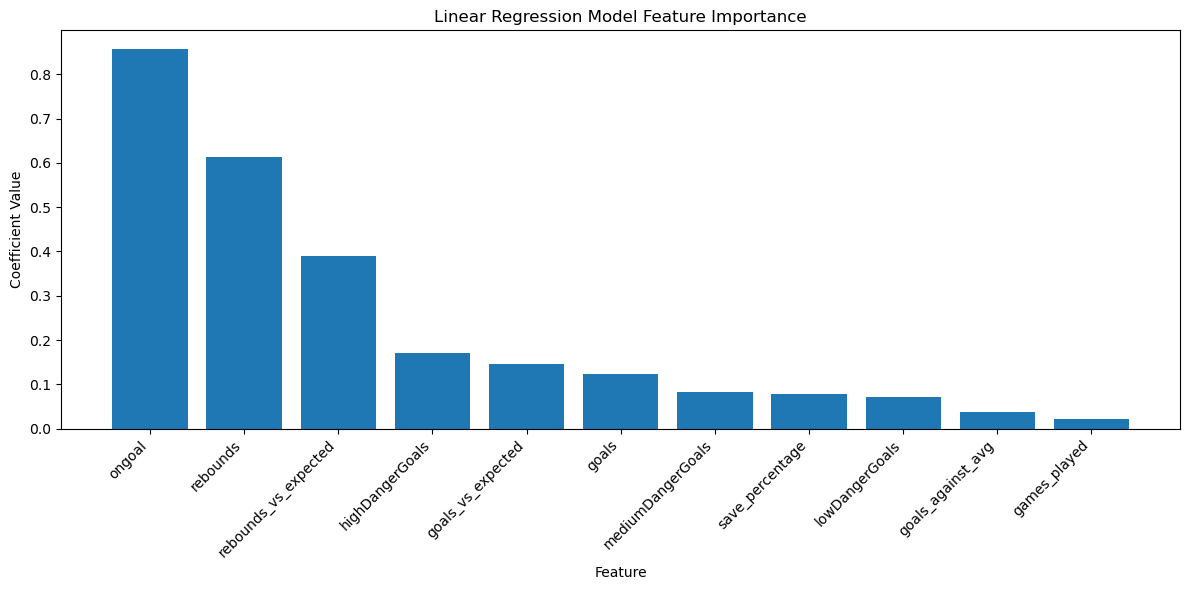

In [268]:
feature_importance_df: pl.DataFrame = pl.DataFrame({
    "feature": train_df.drop(dont_train_cols).columns,
    "importance": abs(linear_regression_ml.coef_)
}).sort("importance", descending=True)

# plotting the data
plt.figure(figsize=(12, 6))

plt.bar(feature_importance_df["feature"], feature_importance_df["importance"])
plt.title("Linear Regression Model Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()